# Data anlaysis

In [1]:
# imports and setup
from   ast import literal_eval
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from   scipy.stats import permutation_test
import seaborn as sns
import string
import warnings

# locations
data_dir    = os.path.join('..', 'data')
derived_dir = os.path.join(data_dir, 'derived')
fig_dir     = os.path.join('..', 'figures')
all_file    = 'all.csv.gz'

# settings
vis_formats = [
    'png',
    'svg',
]

## Load data

In [2]:
def string_to_list(x):
    lst = literal_eval(x.replace(', nan', "', ZZZZ'").replace('[nan, ', "'['").replace(', nan]', "']'"))
    return [i for i in lst if i != 'ZZZZ']

data = pd.read_csv(
    os.path.join(derived_dir, all_file),
    index_col='book_id',
    converters={
        'gpe_places': string_to_list,
        'nongpe_places': string_to_list,
        'all_places': string_to_list,
        'gpe_sequences': string_to_list
    },
)

## Basic corpus stats

In [3]:
# rename collections for better legibility
data.replace(
    {'collection':
       {
            'conlit':'CONLIT',
            'chicago_1':'Chicago I',
            'chicago_2':'Chicago II',
            'wright':'Wright',
            'eaf':'EAF'
        }
    },
    inplace=True
)

# convenience subcorpora
early  = data.loc[data.collection!='CONLIT']
conlit = data.loc[data.collection=='CONLIT']

# total volumes
print(f"Volumes in corpus: {len(data)}")

Volumes in corpus: 13383


In [4]:
print(f"Volumes in EARLY: {len(early)}")

Volumes in EARLY: 10629


In [5]:
print("Stats by subcorpus")
data[['collection', 'pub_date']].groupby('collection').describe()

Stats by subcorpus


pub_date                                                          \
              count         mean        std     min     25%     50%     75%   
collection                                                                    
CONLIT       2754.0  2013.319172   2.910859  2001.0  2012.0  2014.0  2015.0   
Chicago I    2608.0  1921.407209  16.567741  1880.0  1909.0  1924.0  1936.0   
Chicago II   6481.0  1982.770714  15.263748  1946.0  1974.0  1988.0  1995.0   
EAF           488.0  1835.625000  12.612075  1789.0  1831.0  1838.0  1845.0   
Wright       1052.0  1862.470532   7.850536  1837.0  1855.0  1863.0  1869.0   

                    
               max  
collection          
CONLIT      2021.0  
Chicago I   1945.0  
Chicago II  2000.0  
EAF         1850.0  
Wright      1875.0

## Feature differences by facet 

Below are significance-tested measures of features across facets of the corpus. These are not the same thing as the regression models presented in the article.

### CONLIT

In [6]:
def significance_label(pvalue, levels=[0.05, 0.01, 0.001]):
    if pvalue < levels[2]:
        return '***'
    elif pvalue < levels[1]:
        return '**'
    elif pvalue < levels[0]:
        return '*'
    else: 
        return ''

def diff_means(x, y, axis):
    return np.nanmean(x, axis=axis) - np.nanmean(y, axis=axis)

def compare_facets(df, facets, cols_to_drop, statistic=diff_means):
    '''Compare statistic in numeric cols of df via permutation. Display results, return nothing.'''
    cols = df.select_dtypes(include='number').drop(columns=cols_to_drop).columns
    for facet in facets:
        print(f"\n==============\nFacet: {facet}\n==============")           
        df = df.dropna(subset=[facet])
        if facet != 'Category': # unless comparing FIC to NON, drop NON
            df = df.loc[df.Category=='FIC']
            
        if facet == 'inf_gender': # only keep she/her and he/him characters when comparing genders
            df = df.loc[df[facet].isin(set(['she/her/hers', 'he/him/his']))]
        elif facet == 'author_gender': # ditto M/F only for authors
            df = df.loc[df[facet].isin(set(['F', 'M']))]

        if df[facet].nunique() == 1:
            pass
        if df[facet].nunique() == 2:
            level1, level2 = df[facet].unique()
            data = (df.loc[df[facet]==level1, cols], df.loc[df[facet]==level2, cols])
            level_mean = np.mean(data[0], axis=0)
            other_mean = np.mean(data[1], axis=0)
            output = pd.DataFrame(level_mean, columns=[level1]).join(pd.DataFrame(other_mean, columns=[level2]))
            res = permutation_test(data, statistic, n_resamples=2500)
            output['diff'] = res.statistic
            output['p'] = res.pvalue
            output['sig'] = output['p'].apply(significance_label)
            display(output)            
        else:
            for level in df[facet].unique():
                data = (df.loc[df[facet]==level, cols], df.loc[~(df[facet]==level), cols])
                level_mean = np.mean(data[0], axis=0)
                other_mean = np.mean(data[1], axis=0)
                output = pd.DataFrame(level_mean, columns=[level]).join(pd.DataFrame(other_mean, columns=['others']))
                res = permutation_test(data, statistic, n_resamples=2500)
                output['diff'] = res.statistic
                output['p'] = res.pvalue
                output['sig'] = output['p'].apply(significance_label)
                display(output)

In [7]:
facet_by = ['Category', 'inf_gender', 'author_gender', 'perspective', 'Genre']
ignore_numeric_cols = ['char_id', 'char_rank', 'num_words']
compare_facets(conlit, facet_by, ignore_numeric_cols, diff_means)


Facet: Category


,FIC,NON,diff,p,sig
char_count,4201.894519,2884.367073,1317.527446,0.000800,***
num_gpe_places,13.344881,35.776829,-22.431948,0.000800,***
num_nongpe_places,123.875388,120.786585,3.088802,0.322271,
num_all_places,136.805584,155.698780,-18.893196,0.000800,***
dist_miles,38024.078670,131262.735676,-93238.657006,0.000800,***
Tokens,121620.681489,142400.906098,-20780.224608,0.000800,***
num_gpe_places_norm,0.000117,0.000263,-0.000145,0.000800,***
num_nongpe_places_norm,0.001116,0.000970,0.000146,0.000800,***
num_gpe_places_norm_byCharacter,0.003816,0.018413,-0.014597,0.000800,***
num_nongpe_places_norm_byCharacter,0.033306,0.046310,-0.013004,0.000800,***



Facet: inf_gender


,she/her/hers,he/him/his,diff,p,sig
char_count,3869.822581,4419.452542,-5.496300e+02,0.000800,***
num_gpe_places,12.211022,13.991525,-1.780504e+00,0.000800,***
num_nongpe_places,119.575269,126.536441,-6.961172e+00,0.013595,*
num_all_places,131.372312,140.116949,-8.744637e+00,0.002399,**
dist_miles,35721.668613,39372.905574,-3.651237e+03,0.138345,
Tokens,116767.427419,124867.428814,-8.100001e+03,0.005598,**
num_gpe_places_norm,0.000112,0.000120,-7.332272e-06,0.093563,
num_nongpe_places_norm,0.001117,0.001113,3.798993e-06,0.856457,
num_gpe_places_norm_byCharacter,0.003544,0.003949,-4.059017e-04,0.005598,**
num_nongpe_places_norm_byCharacter,0.033896,0.032826,1.070398e-03,0.063974,



Facet: author_gender


,F,M,diff,p,sig
char_count,4644.710037,3643.078571,1001.631466,0.000800,***
num_gpe_places,11.391264,15.770238,-4.378974,0.000800,***
num_nongpe_places,122.588290,125.415476,-2.827186,0.285486,
num_all_places,133.612454,140.714286,-7.101832,0.015194,*
dist_miles,31076.145753,46890.310138,-15814.164384,0.000800,***
Tokens,113823.980483,132061.921429,-18237.940945,0.000800,***
num_gpe_places_norm,0.000106,0.000130,-0.000024,0.000800,***
num_nongpe_places_norm,0.001150,0.001068,0.000081,0.000800,***
num_gpe_places_norm_byCharacter,0.002984,0.004834,-0.001850,0.000800,***
num_nongpe_places_norm_byCharacter,0.030522,0.036738,-0.006216,0.000800,***



Facet: perspective


,other,first,diff,p,sig
char_count,3297.110643,5097.141675,-1800.031033,0.000800,***
num_gpe_places,11.762908,14.830403,-3.067495,0.000800,***
num_nongpe_places,107.978925,139.381593,-31.402667,0.000800,***
num_all_places,119.384615,153.744571,-34.359955,0.000800,***
dist_miles,31431.100424,44465.024864,-13033.924440,0.000800,***
Tokens,130355.756586,113442.610134,16913.146451,0.000800,***
num_gpe_places_norm,0.000095,0.000138,-0.000043,0.000800,***
num_nongpe_places_norm,0.000914,0.001310,-0.000395,0.000800,***
num_gpe_places_norm_byCharacter,0.003987,0.003607,0.000380,0.007197,**
num_nongpe_places_norm_byCharacter,0.035071,0.031458,0.003614,0.000800,***



Facet: Genre


,YA,others,diff,p,sig
char_count,5656.602273,4058.811494,1597.790778,0.000800,***
num_gpe_places,11.539773,13.490230,-1.950457,0.019992,*
num_nongpe_places,130.767045,123.125862,7.641183,0.107957,
num_all_places,141.875000,136.205172,5.669828,0.275890,
dist_miles,28865.073812,38934.218595,-10069.144784,0.008796,**
Tokens,106003.238636,123419.567241,-17416.328605,0.000800,***
num_gpe_places_norm,0.000114,0.000117,-0.000004,0.625350,
num_nongpe_places_norm,0.001257,0.001099,0.000158,0.000800,***
num_gpe_places_norm_byCharacter,0.002366,0.003940,-0.001573,0.000800,***
num_nongpe_places_norm_byCharacter,0.024401,0.034142,-0.009741,0.000800,***


,SF,others,diff,p,sig
char_count,3816.963303,4255.474676,-438.511373,0.012795,*
num_gpe_places,12.559633,13.407538,-0.847905,0.269492,
num_nongpe_places,114.935780,124.969376,-10.033596,0.019192,*
num_all_places,126.899083,137.987633,-11.088550,0.019992,*
dist_miles,30941.681274,38916.670688,-7974.989414,0.027989,*
Tokens,144582.059633,118897.366313,25684.693320,0.000800,***
num_gpe_places_norm,0.000097,0.000120,-0.000023,0.000800,***
num_nongpe_places_norm,0.000889,0.001143,-0.000253,0.000800,***
num_gpe_places_norm_byCharacter,0.003720,0.003805,-0.000084,0.702919,
num_nongpe_places_norm_byCharacter,0.031726,0.033443,-0.001716,0.060776,


,BS,others,diff,p,sig
char_count,4732.879032,4127.182254,605.696778,0.003199,**
num_gpe_places,17.459677,12.694245,4.765433,0.000800,***
num_nongpe_places,143.322581,120.929257,22.393324,0.000800,***
num_all_places,160.282258,133.223621,27.058637,0.000800,***
dist_miles,48957.187351,36381.541297,12575.646054,0.001599,**
Tokens,155174.580645,116860.504197,38314.076449,0.000800,***
num_gpe_places_norm,0.000125,0.000116,0.000009,0.159936,
num_nongpe_places_norm,0.001016,0.001129,-0.000113,0.001599,**
num_gpe_places_norm_byCharacter,0.004558,0.003682,0.000876,0.000800,***
num_nongpe_places_norm_byCharacter,0.034952,0.032994,0.001958,0.021591,*


,NYT,others,diff,p,sig
char_count,3719.703349,4341.160214,-621.456864,0.000800,***
num_gpe_places,16.351675,12.462617,3.889058,0.000800,***
num_nongpe_places,129.624402,122.210280,7.414122,0.027189,*
num_all_places,145.581340,134.255007,11.326333,0.002399,**
dist_miles,52104.402460,34076.203684,18028.198776,0.000800,***
Tokens,118268.789474,122810.589453,-4541.799979,0.164734,
num_gpe_places_norm,0.000150,0.000108,0.000042,0.000800,***
num_nongpe_places_norm,0.001194,0.001092,0.000102,0.001599,**
num_gpe_places_norm_byCharacter,0.004899,0.003487,0.001412,0.000800,***
num_nongpe_places_norm_byCharacter,0.037954,0.031934,0.006020,0.000800,***


,MY,others,diff,p,sig
char_count,4094.965217,4220.671412,-125.706194,0.492603,
num_gpe_places,13.247826,13.319692,-0.071865,0.904438,
num_nongpe_places,132.034783,122.708185,9.326598,0.032787,*
num_all_places,144.900000,135.610913,9.289087,0.055978,
dist_miles,33428.516919,38634.184137,-5205.667218,0.143942,
Tokens,124692.878261,121427.790629,3265.087632,0.446222,
num_gpe_places_norm,0.000109,0.000118,-0.000010,0.123151,
num_nongpe_places_norm,0.001111,0.001114,-0.000003,0.936425,
num_gpe_places_norm_byCharacter,0.003719,0.003805,-0.000086,0.672531,
num_nongpe_places_norm_byCharacter,0.034123,0.033128,0.000995,0.269492,


,ROM,others,diff,p,sig
char_count,5964.347826,3992.553540,1971.794286,0.000800,***
num_gpe_places,7.613527,14.001170,-6.387644,0.000800,***
num_nongpe_places,108.797101,125.648332,-16.851231,0.000800,***
num_all_places,116.198068,139.212405,-23.014337,0.000800,***
dist_miles,20892.495650,40082.531742,-19190.036092,0.000800,***
Tokens,103463.314010,124043.131071,-20579.817061,0.000800,***
num_gpe_places_norm,0.000075,0.000122,-0.000047,0.000800,***
num_nongpe_places_norm,0.001099,0.001116,-0.000017,0.645342,
num_gpe_places_norm_byCharacter,0.001397,0.004085,-0.002688,0.000800,***
num_nongpe_places_norm_byCharacter,0.019868,0.034868,-0.015001,0.000800,***


,PW,others,diff,p,sig
char_count,3185.085938,4362.959036,-1177.873099,0.000800,***
num_gpe_places,14.812500,13.079518,1.732982,0.015194,*
num_nongpe_places,121.613281,124.169277,-2.555996,0.515794,
num_all_places,135.976562,136.841566,-0.865004,0.846062,
dist_miles,49134.962572,36293.519836,12841.442736,0.001599,**
Tokens,122486.812500,121716.863253,769.949247,0.839664,
num_gpe_places_norm,0.000134,0.000114,0.000020,0.001599,**
num_nongpe_places_norm,0.001108,0.001115,-0.000007,0.832467,
num_gpe_places_norm_byCharacter,0.005177,0.003582,0.001595,0.000800,***
num_nongpe_places_norm_byCharacter,0.042256,0.031858,0.010398,0.000800,***


,MID,others,diff,p,sig
char_count,3127.607362,4305.815174,-1178.207812,0.000800,***
num_gpe_places,7.085890,13.889903,-6.804013,0.000800,***
num_nongpe_places,94.687117,126.537365,-31.850248,0.000800,***
num_all_places,101.472393,140.003993,-38.531601,0.000800,***
dist_miles,15259.970781,40124.596754,-24864.625973,0.000800,***
Tokens,85022.184049,125241.301198,-40219.117149,0.000800,***
num_gpe_places_norm,0.000089,0.000120,-0.000030,0.000800,***
num_nongpe_places_norm,0.001237,0.001102,0.000135,0.001599,**
num_gpe_places_norm_byCharacter,0.002427,0.003922,-0.001495,0.000800,***
num_nongpe_places_norm_byCharacter,0.031779,0.033384,-0.001605,0.139144,


### EARLY

In [8]:
facet_by = ['inf_gender', 'author_gender', 'perspective', 'collection']
ignore_numeric_cols = ['char_id', 'char_rank', 'num_words', 'dist_miles_allChars', 'dist_miles_allChars_norm_Tokens', 'num_gpe_places_allChars_norm_Tokens']
compare_facets(early, facet_by, ignore_numeric_cols, diff_means)


Facet: inf_gender


,she/her/hers,he/him/his,diff,p,sig
char_count,3148.029474,2828.611755,319.417719,0.000800,***
num_gpe_places,10.821955,11.499034,-0.677079,0.001599,**
num_nongpe_places,98.030075,90.826021,7.204054,0.000800,***
num_all_places,108.525714,102.010624,6.515091,0.000800,***
dist_miles,28650.123003,29791.288819,-1141.165815,0.251100,
Tokens,119375.848120,114162.008002,5213.840118,0.000800,***
num_gpe_places_norm,0.000096,0.000106,-0.000011,0.000800,***
num_nongpe_places_norm,0.000880,0.000851,0.000028,0.005598,**
num_gpe_places_norm_byCharacter,0.003715,0.004595,-0.000880,0.000800,***
num_nongpe_places_norm_byCharacter,0.033425,0.034077,-0.000652,0.017593,*



Facet: author_gender


,M,F,diff,p,sig
char_count,2763.582915,3275.017881,-511.434966,0.000800,***
num_gpe_places,11.805138,10.569255,1.235882,0.000800,***
num_nongpe_places,89.594315,101.107286,-11.512971,0.000800,***
num_all_places,101.076455,111.358153,-10.281698,0.000800,***
dist_miles,30344.014705,28449.021111,1894.993594,0.051180,
Tokens,114053.214014,120460.216173,-6407.002159,0.000800,***
num_gpe_places_norm,0.000109,0.000092,0.000017,0.000800,***
num_nongpe_places_norm,0.000841,0.000900,-0.000059,0.000800,***
num_gpe_places_norm_byCharacter,0.004768,0.003510,0.001258,0.000800,***
num_nongpe_places_norm_byCharacter,0.034427,0.032832,0.001594,0.000800,***



Facet: perspective


,other,first,diff,p,sig
char_count,2818.873517,3212.730679,-393.857163,0.000800,***
num_gpe_places,10.095369,13.908080,-3.812711,0.000800,***
num_nongpe_places,88.367873,104.703747,-16.335874,0.000800,***
num_all_places,98.158900,118.256148,-20.097247,0.000800,***
dist_miles,25390.466562,38285.606235,-12895.139673,0.000800,***
Tokens,121589.599855,105836.179742,15753.420113,0.000800,***
num_gpe_places_norm,0.000087,0.000136,-0.000049,0.000800,***
num_nongpe_places_norm,0.000779,0.001030,-0.000251,0.000800,***
num_gpe_places_norm_byCharacter,0.004004,0.004935,-0.000931,0.000800,***
num_nongpe_places_norm_byCharacter,0.033590,0.034369,-0.000779,0.004798,**



Facet: collection


,Chicago I,others,diff,p,sig
char_count,2394.087706,3131.575399,-737.487693,0.000800,***
num_gpe_places,8.424041,12.320381,-3.896340,0.000800,***
num_nongpe_places,73.238058,100.519815,-27.281757,0.000800,***
num_all_places,81.436179,112.487519,-31.051341,0.000800,***
dist_miles,21166.559506,32446.263750,-11279.704244,0.000800,***
Tokens,101652.092404,121217.329002,-19565.236597,0.000800,***
num_gpe_places_norm,0.000087,0.000108,-0.000021,0.000800,***
num_nongpe_places_norm,0.000769,0.000893,-0.000124,0.000800,***
num_gpe_places_norm_byCharacter,0.004142,0.004367,-0.000225,0.009596,**
num_nongpe_places_norm_byCharacter,0.033261,0.034041,-0.000780,0.007997,**


,Chicago II,others,diff,p,sig
char_count,3481.469074,2092.049039,1389.420034,0.000800,***
num_gpe_places,13.807535,7.410263,6.397272,0.000800,***
num_nongpe_places,113.278022,62.363246,50.914776,0.000800,***
num_all_places,126.669702,69.604398,57.065303,0.000800,***
dist_miles,37043.097004,17762.190832,19280.906172,0.000800,***
Tokens,127461.787441,98531.076593,28930.710849,0.000800,***
num_gpe_places_norm,0.000117,0.000081,0.000037,0.000800,***
num_nongpe_places_norm,0.000976,0.000680,0.000296,0.000800,***
num_gpe_places_norm_byCharacter,0.004386,0.004192,0.000194,0.019992,*
num_nongpe_places_norm_byCharacter,0.034687,0.032497,0.002191,0.000800,***


,EAF,others,diff,p,sig
char_count,1287.102174,3026.660957,-1739.558783,0.000800,***
num_gpe_places,5.858696,11.613014,-5.754319,0.000800,***
num_nongpe_places,37.632609,96.389520,-58.756911,0.000800,***
num_all_places,43.458696,107.667748,-64.209052,0.000800,***
dist_miles,13302.267721,30418.884218,-17116.616497,0.000800,***
Tokens,87988.073913,117701.805291,-29713.731378,0.000800,***
num_gpe_places_norm,0.000069,0.000105,-0.000036,0.000800,***
num_nongpe_places_norm,0.000485,0.000880,-0.000395,0.000800,***
num_gpe_places_norm_byCharacter,0.005030,0.004278,0.000751,0.002399,**
num_nongpe_places_norm_byCharacter,0.032907,0.033892,-0.000985,0.093563,


,Wright,others,diff,p,sig
char_count,1666.219745,3077.954497,-1411.734752,0.000800,***
num_gpe_places,5.419321,11.952685,-6.533365,0.000800,***
num_nongpe_places,44.955414,98.672421,-53.717007,0.000800,***
num_all_places,50.292994,110.279731,-59.986738,0.000800,***
dist_miles,10709.969001,31558.286876,-20848.317875,0.000800,***
Tokens,95217.601911,118502.295823,-23284.693912,0.000800,***
num_gpe_places_norm,0.000068,0.000107,-0.000039,0.000800,***
num_nongpe_places_norm,0.000534,0.000895,-0.000362,0.000800,***
num_gpe_places_norm_byCharacter,0.003919,0.004351,-0.000432,0.001599,**
num_nongpe_places_norm_byCharacter,0.030225,0.034212,-0.003987,0.000800,***


## Gender in all fiction data

In [9]:
# restrict to fiction
fic_data_all = data.loc[data.Category=='FIC']
fic_data     = fic_data_all.loc[data.collection!='CONLIT']

In [10]:
facet_by = ['inf_gender', 'author_gender', 'perspective']
ignore_numeric_cols = ['char_id', 'char_rank', 'num_words', 'dist_miles_allChars', 'dist_miles_allChars_norm_Tokens', 'num_gpe_places_allChars_norm_Tokens']
compare_facets(fic_data_all, facet_by, ignore_numeric_cols, diff_means)


Facet: inf_gender


,she/her/hers,he/him/his,diff,p,sig
char_count,3280.006390,3051.344566,228.661824,0.000800,***
num_gpe_places,11.075940,11.848007,-0.772067,0.000800,***
num_nongpe_places,101.969526,95.825819,6.143707,0.000800,***
num_all_places,112.703121,107.345871,5.357250,0.000800,***
dist_miles,29943.126182,31132.806115,-1189.679933,0.175930,
Tokens,118898.909069,115660.868533,3238.040535,0.012795,*
num_gpe_places_norm,0.000099,0.000108,-0.000010,0.000800,***
num_nongpe_places_norm,0.000923,0.000888,0.000035,0.000800,***
num_gpe_places_norm_byCharacter,0.003684,0.004505,-0.000821,0.000800,***
num_nongpe_places_norm_byCharacter,0.033512,0.033902,-0.000390,0.082367,



Facet: author_gender


,F,M,diff,p,sig
char_count,3580.592992,2863.161882,717.431110,0.000800,***
num_gpe_places,10.752644,12.254077,-1.501434,0.000800,***
num_nongpe_places,105.899648,93.650088,12.249560,0.000800,***
num_all_places,116.323035,105.564362,10.758674,0.000800,***
dist_miles,29035.126463,32217.432708,-3182.306244,0.000800,***
Tokens,118979.687539,116092.210406,2887.477133,0.025590,*
num_gpe_places_norm,0.000095,0.000112,-0.000017,0.000800,***
num_nongpe_places_norm,0.000955,0.000867,0.000089,0.000800,***
num_gpe_places_norm_byCharacter,0.003393,0.004776,-0.001383,0.000800,***
num_nongpe_places_norm_byCharacter,0.032317,0.034688,-0.002371,0.000800,***



Facet: perspective


,other,first,diff,p,sig
char_count,2876.622217,3628.479124,-751.856907,0.000800,***
num_gpe_places,10.296730,14.111567,-3.814838,0.000800,***
num_nongpe_places,90.735971,112.354552,-21.618580,0.000800,***
num_all_places,100.721975,126.085786,-25.363811,0.000800,***
dist_miles,26119.892893,39648.941352,-13529.048459,0.000800,***
Tokens,122648.142003,107514.349532,15133.792471,0.000800,***
num_gpe_places_norm,0.000088,0.000136,-0.000049,0.000800,***
num_nongpe_places_norm,0.000796,0.001092,-0.000296,0.000800,***
num_gpe_places_norm_byCharacter,0.004002,0.004642,-0.000640,0.000800,***
num_nongpe_places_norm_byCharacter,0.033769,0.033727,0.000042,0.898840,


## Change over time

### Integrated data colored by corpus

In [11]:
# plot features over time
# use all informative numeric columns
cols_to_drop_from_plot = ['char_id', 'char_rank', 'pub_date']
numeric_cols = fic_data[fic_data.columns[fic_data.notna().all()]].select_dtypes(include='number').drop(columns=cols_to_drop_from_plot).columns

In [12]:
# axis labels
feature_labels = {
    'char_count': 'Protagonist references',
    'num_gpe_places': 'Unique GPEs',
    'num_nongpe_places': 'Unique generic locations',
    'num_all_places': 'Unique locations (all)',
    'dist_miles': 'Distance (miles)',
    'Tokens': 'Tokens',
    'num_gpe_places_norm': 'GPEs/token',
    'num_nongpe_places_norm': 'Generic locations/token',
    'num_gpe_places_norm_byCharacter': 'GPEs/protagonist reference',
    'num_nongpe_places_norm_byCharacter': 'Generic locations/protagist reference',
    'char_count_norm': 'Protagonist references/token',
    'nongpe_places_total': 'Generic location count',
    'gpe_places_total': 'GPE count',
    'ttr_nongpe': 'TTR generic locations',
    'ttr_gpe': 'TTR GPEs',
    'avg_Distance_GPE': 'Distance/GPE',
    'avg_Distance_GPE_Tokens': 'Distance/GPE/token',
    'deixis_count_perplace': 'Deixis/generic location',
    'semantic_dist_mean': 'Semantic distance (mean)',
    'semantic_dist_total': 'Semantic distance (total)',
    'non_gpe_total_rank': 'GPE count (rank)',
    'dist_miles_rank': 'Distance (rank)',
    'dist_miles_norm': 'Distance/token',
    'dist_miles_norm_byCharacter': 'Distance/protagonist reference',
    'gpe_total_rank': 'GPE count (rank)',
    'hops':'Hops',
    'Start_Finish_Miles': 'Start-finish distance'
}

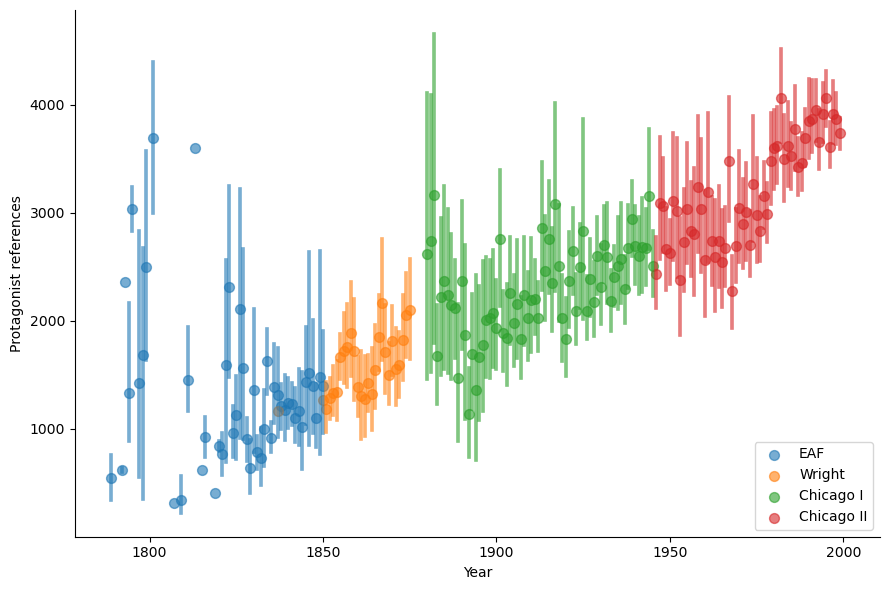

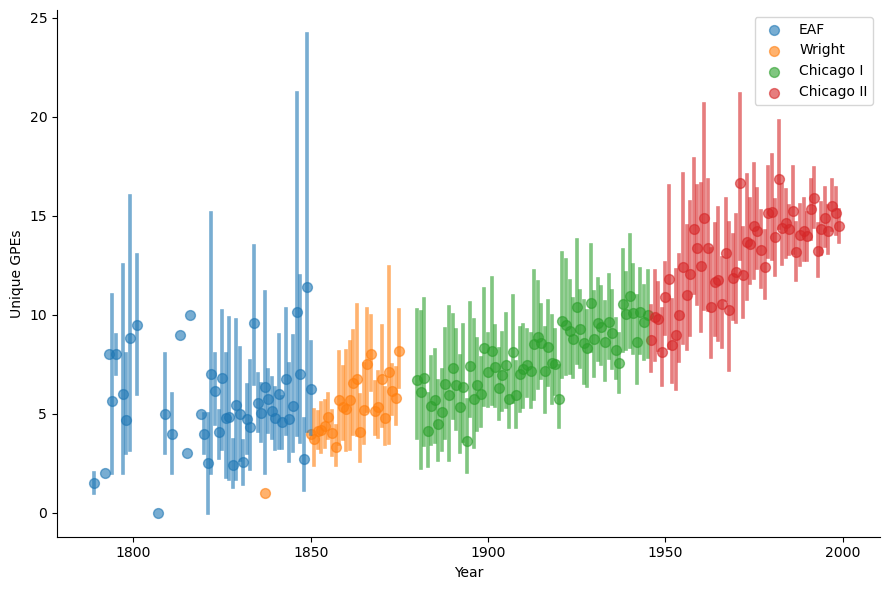

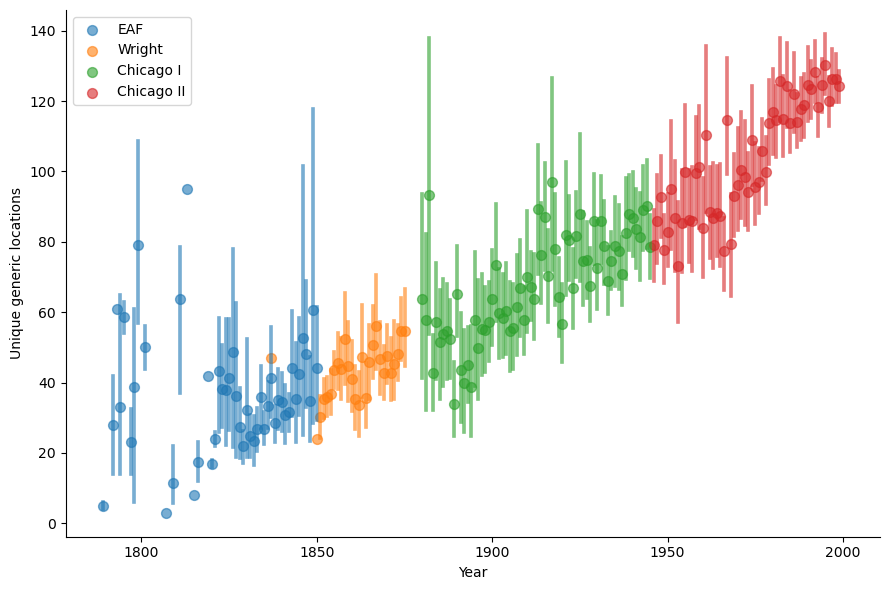

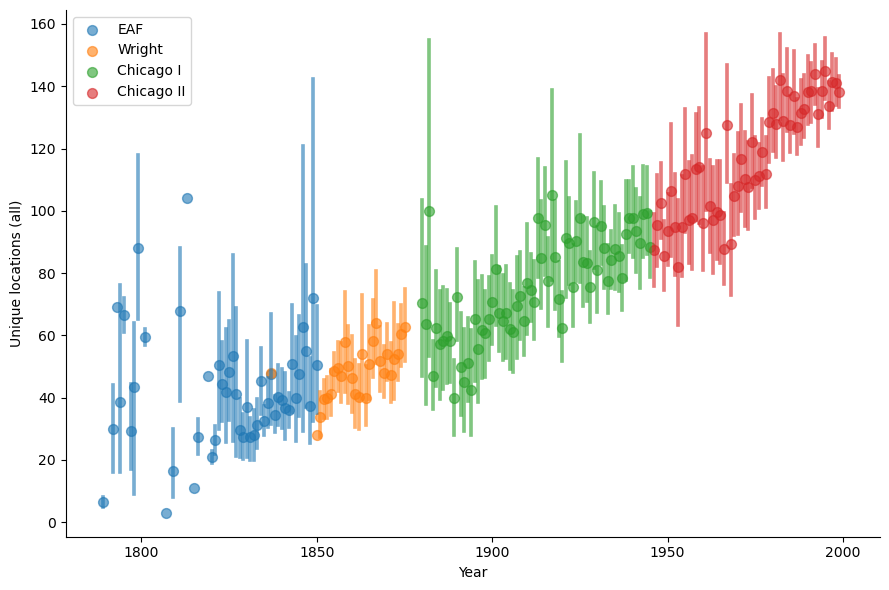

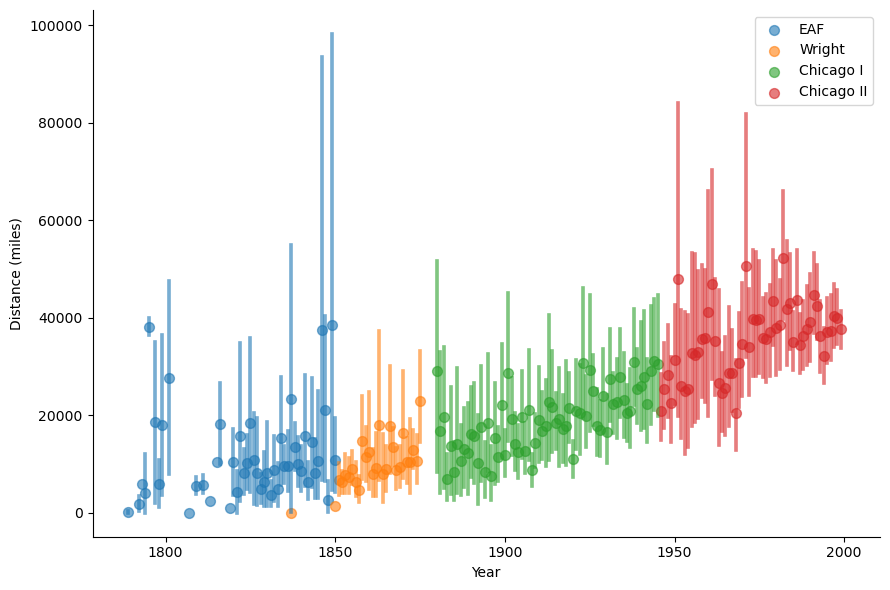

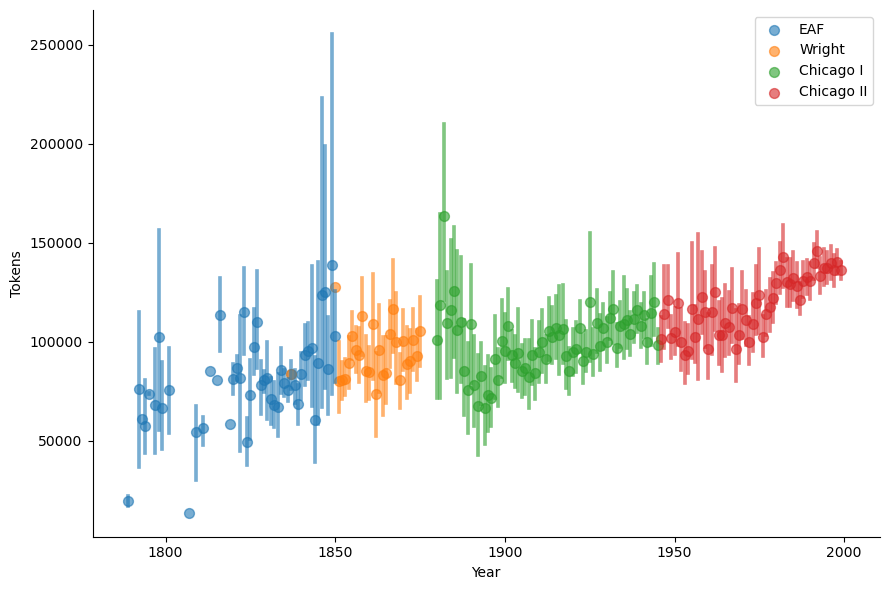

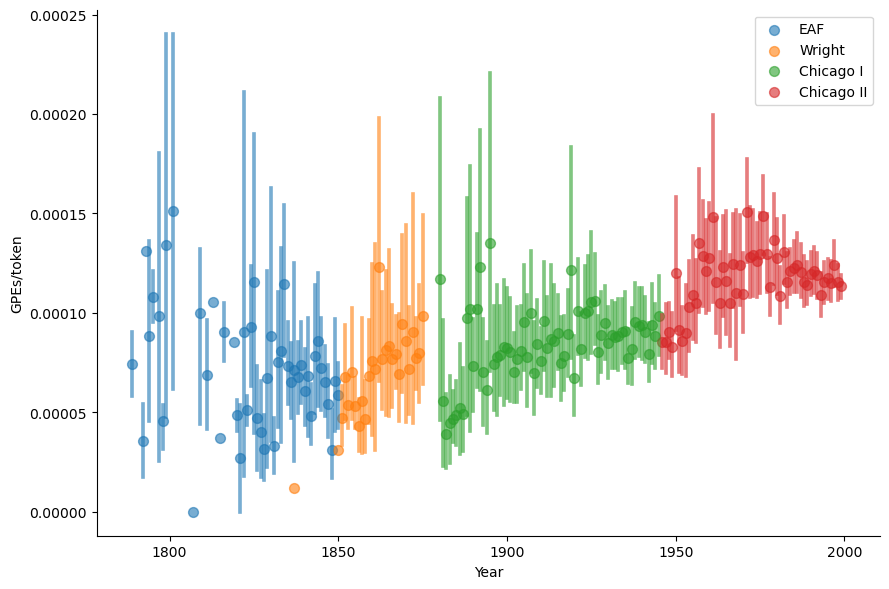

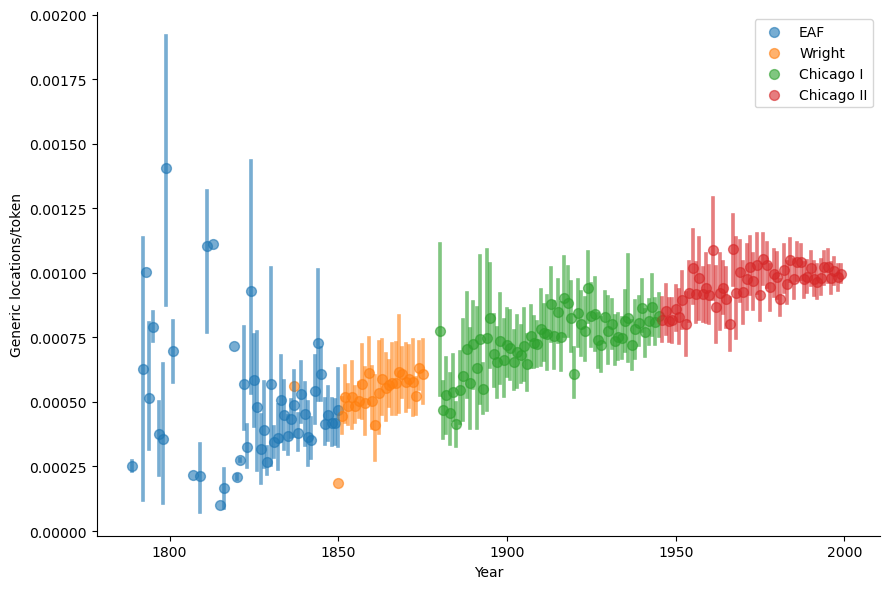

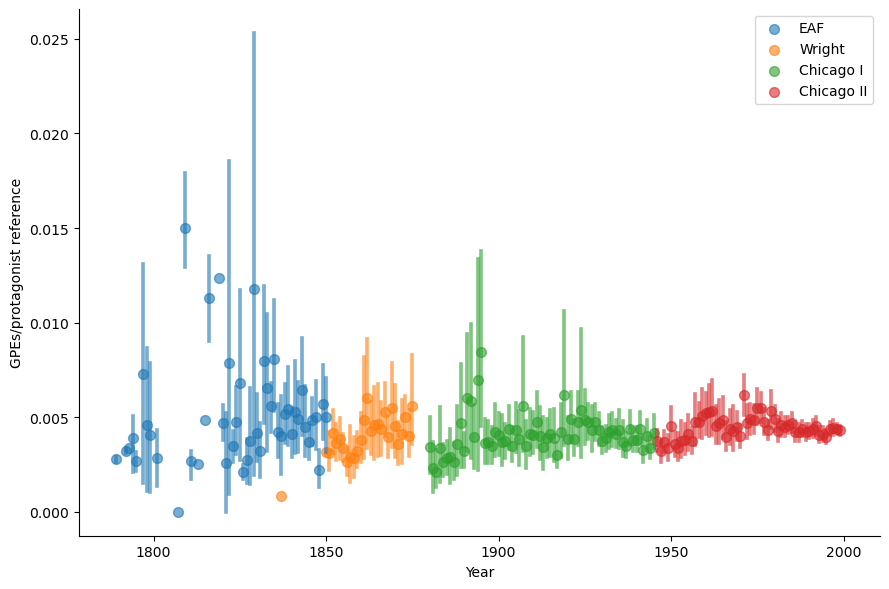

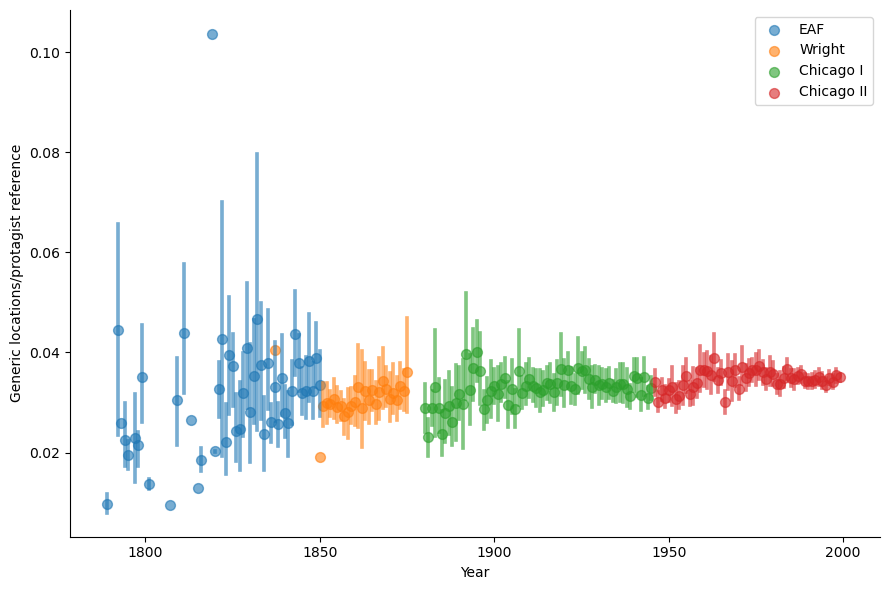

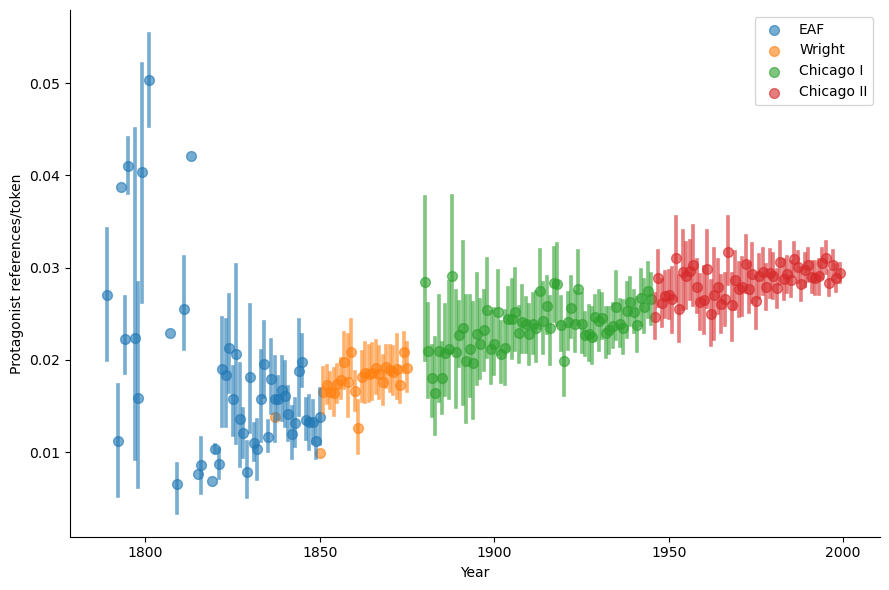

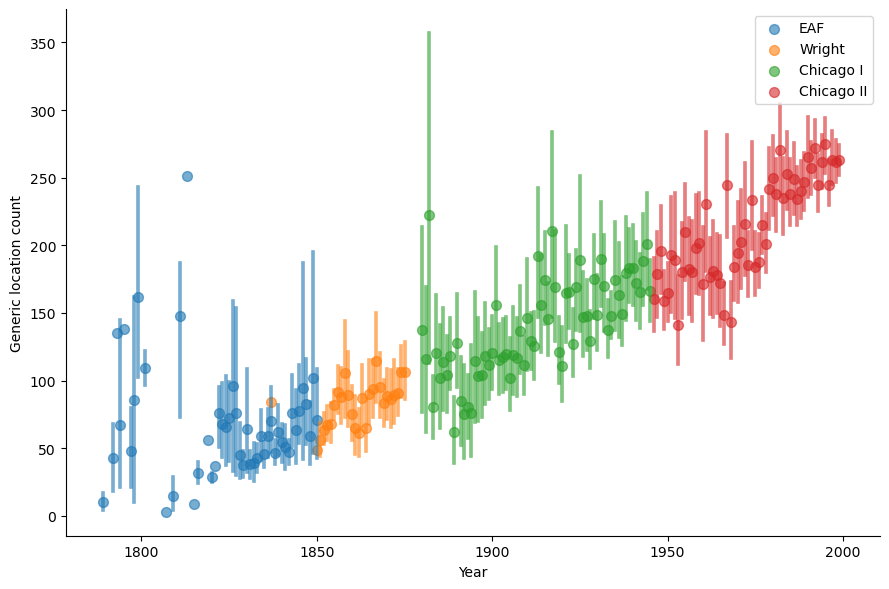

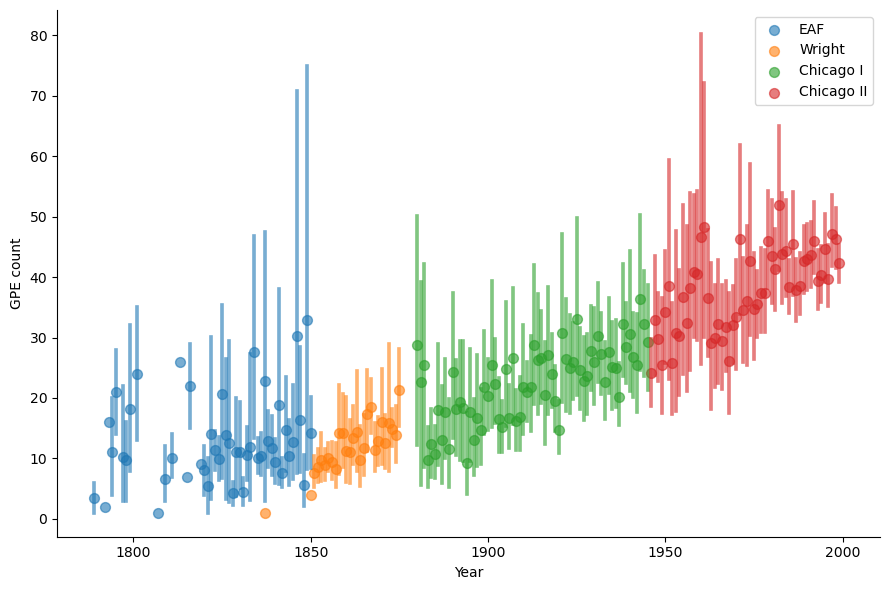

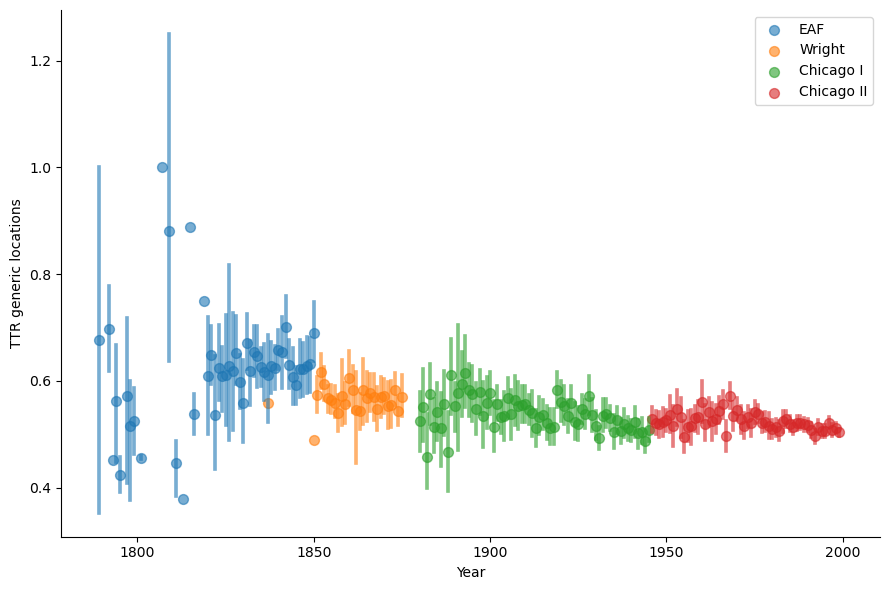

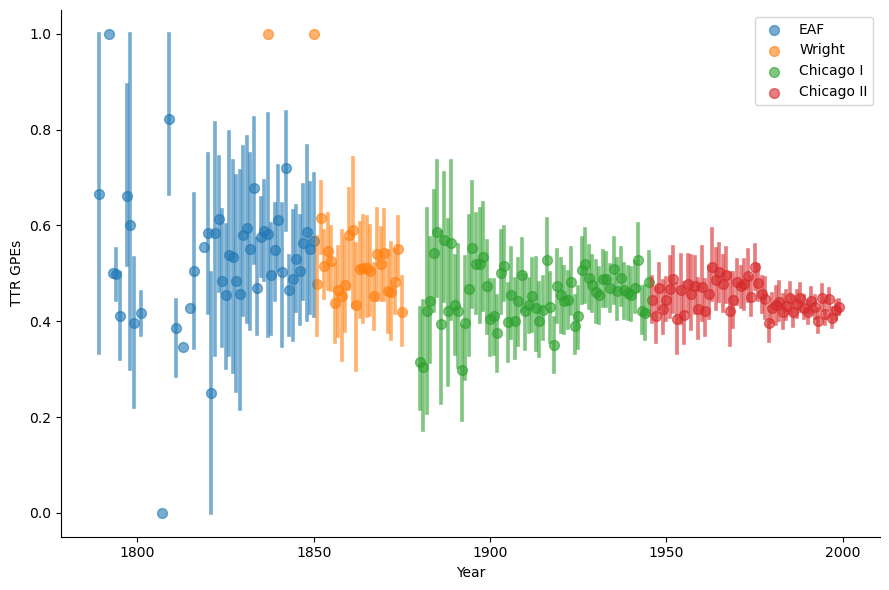

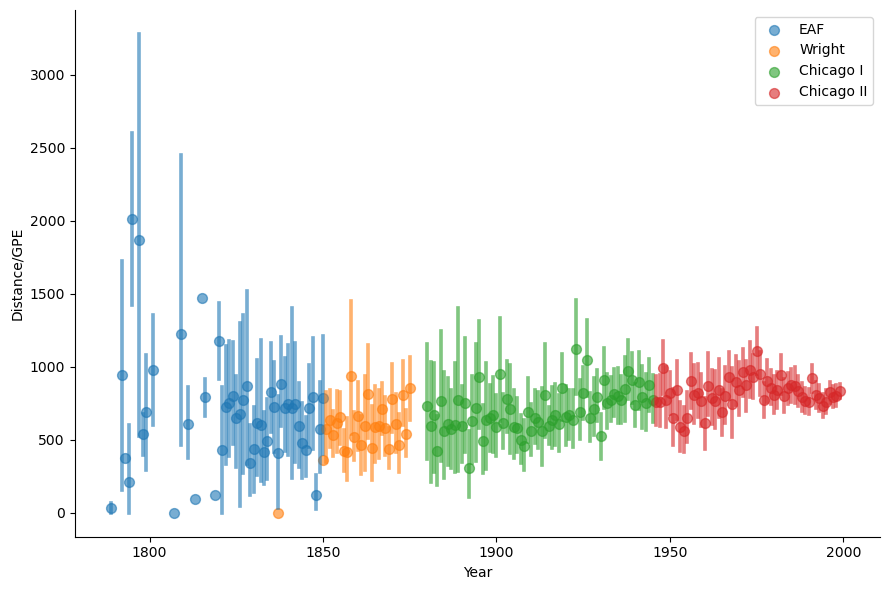

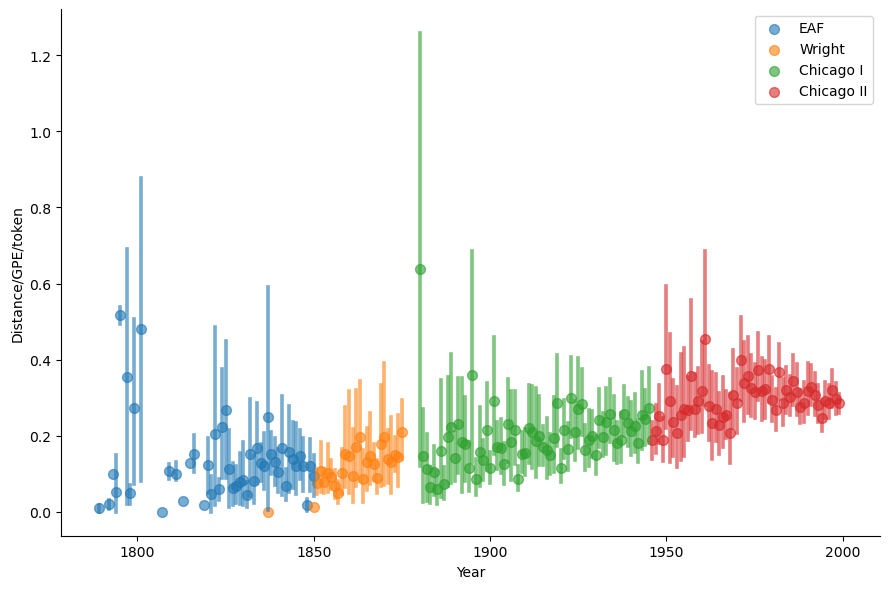

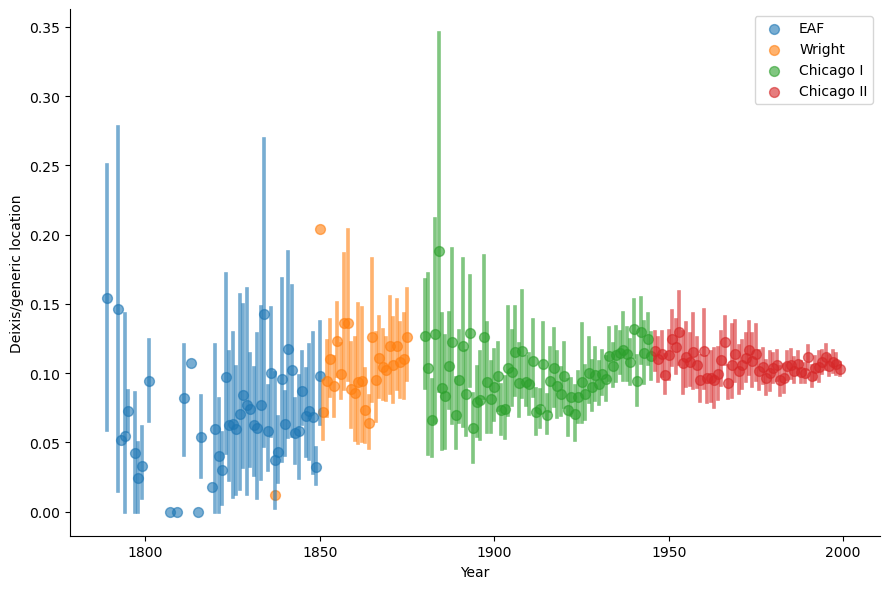

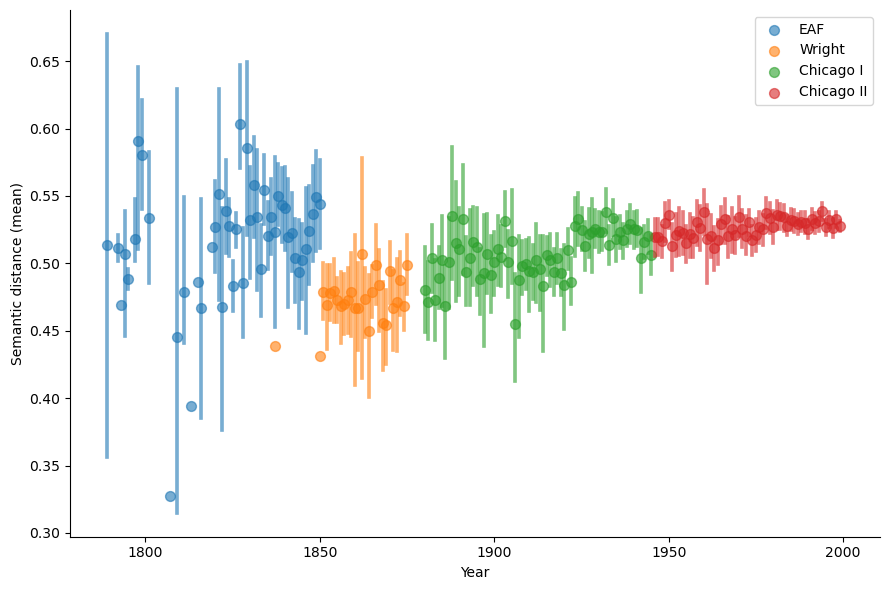

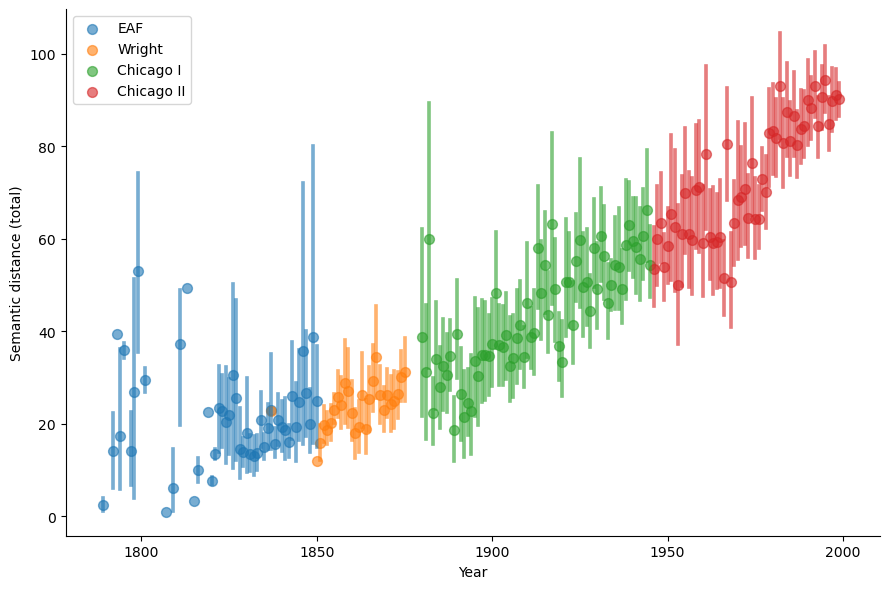

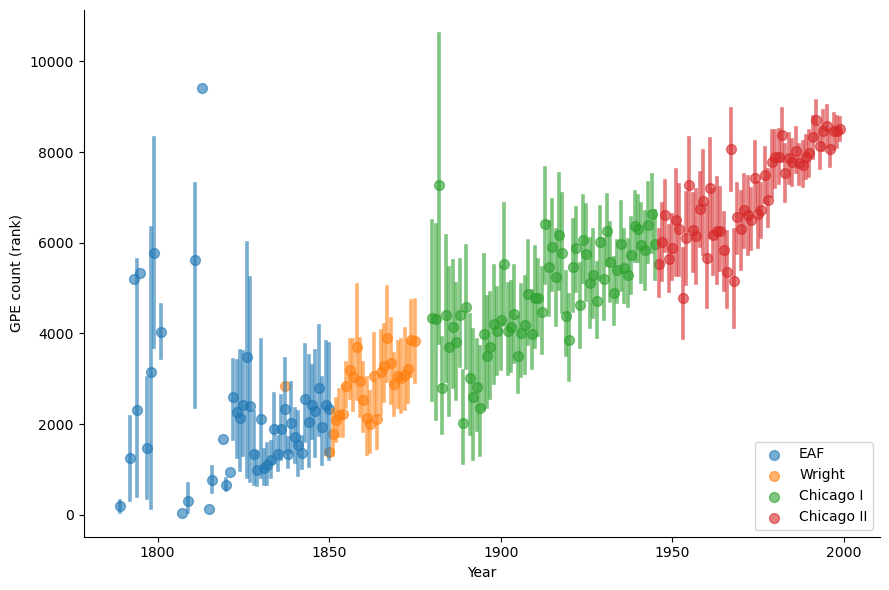

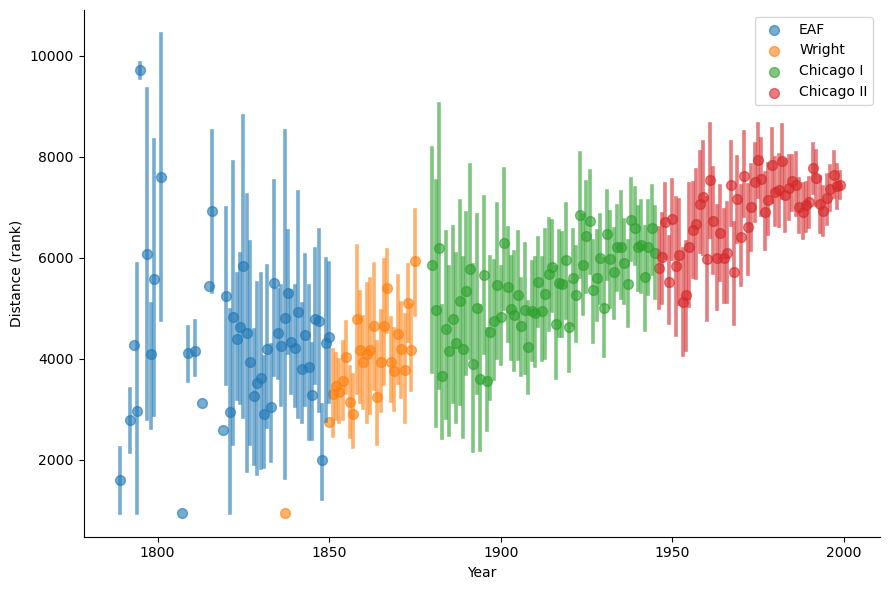

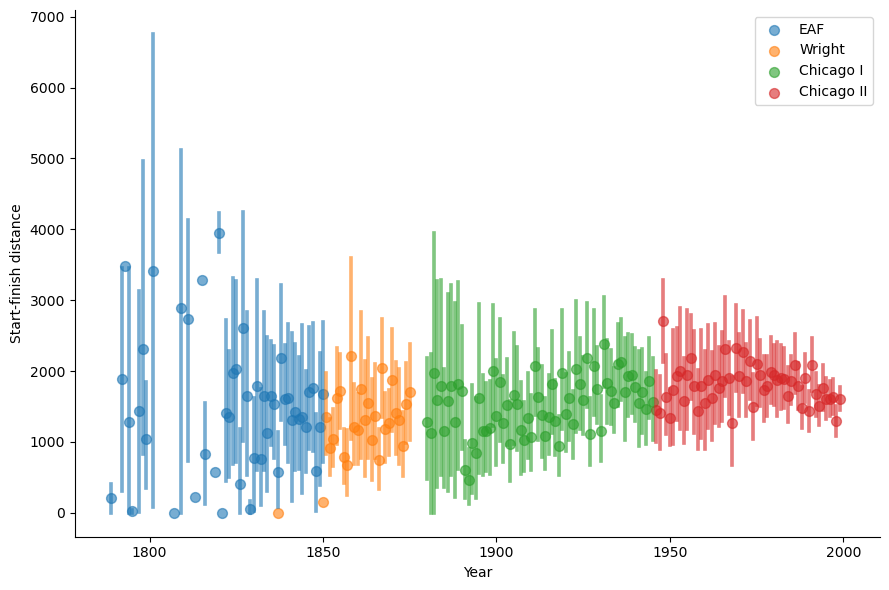

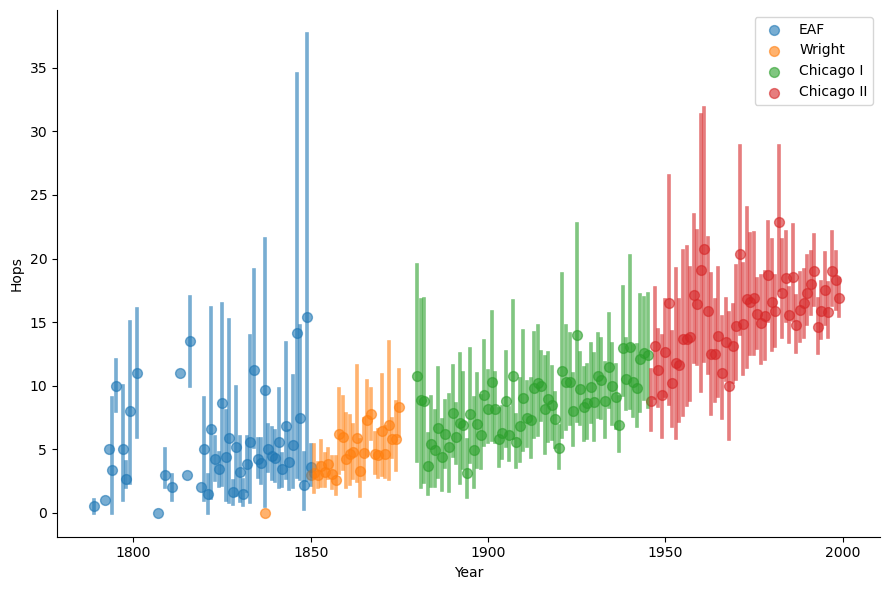

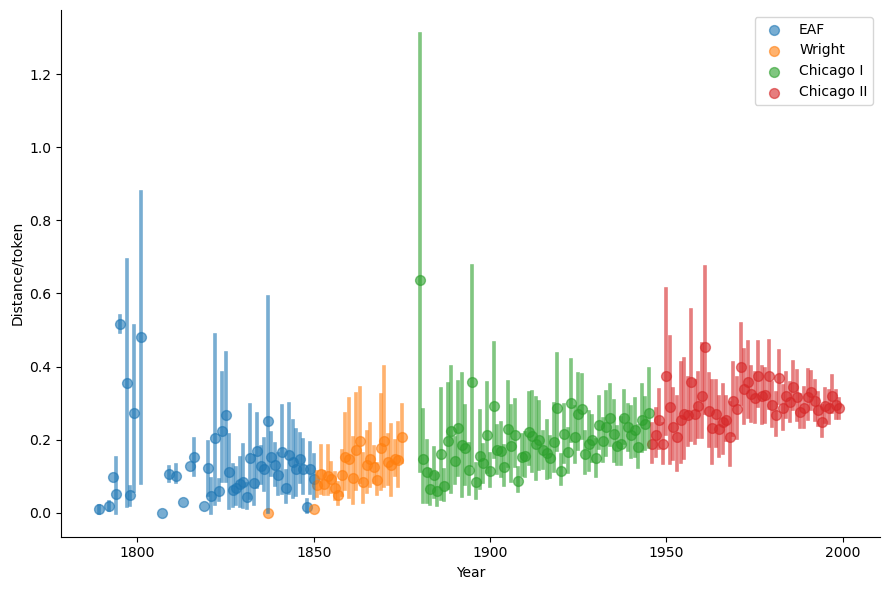

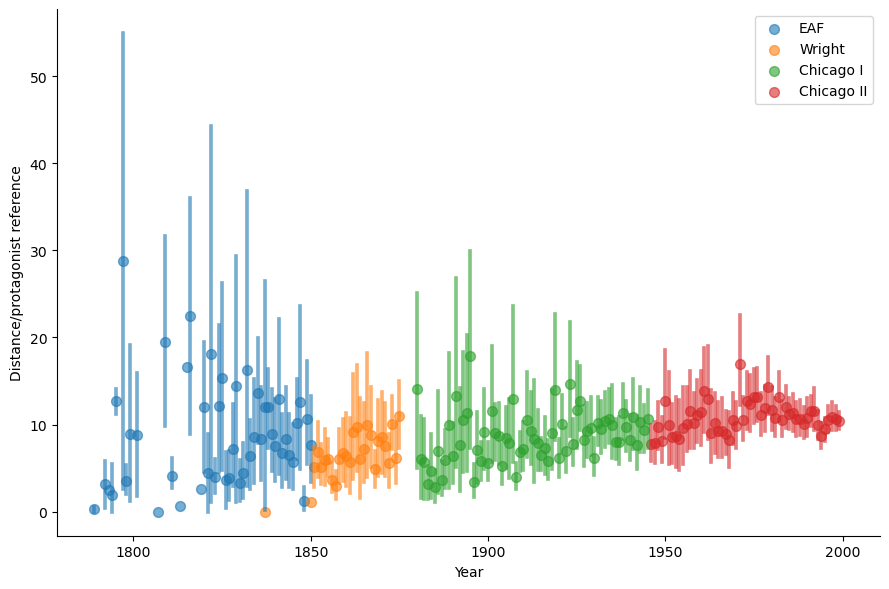

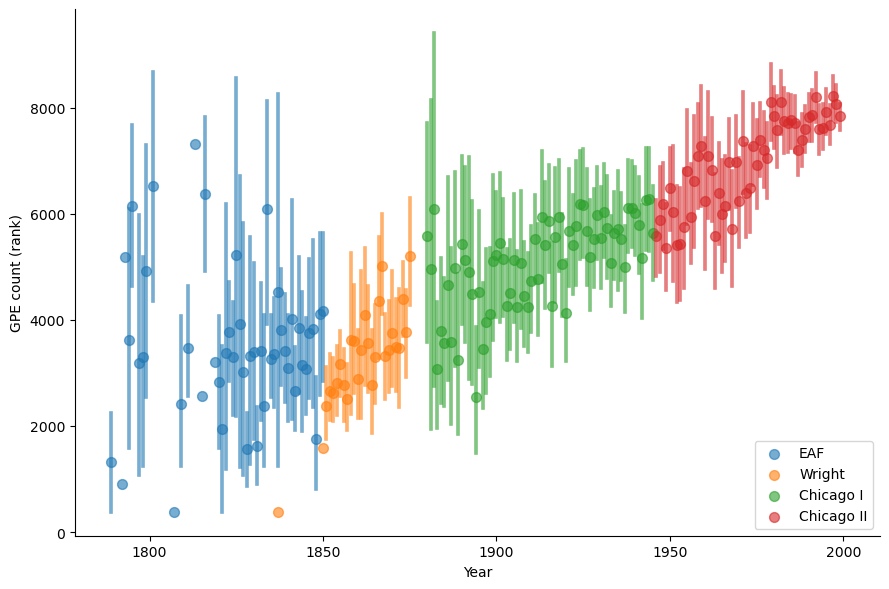

In [13]:
# create plots
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bins = np.arange(fic_data.pub_date.min(), fic_data.pub_date.max(), 1)
    for col in numeric_cols:
        sns.lmplot(
            x='pub_date', 
            y=col, 
            data=fic_data, 
            #y_partial='Category', # control for fiction/nonfiction
            fit_reg=False,
            x_bins=bins, #fixed total bins by year
            #x_bins=10, # number of bins per collection
            hue='collection',
            hue_order=['EAF', 'Wright', 'Chicago I', 'Chicago II'],
            legend=False,
            height=6,
            aspect=1.5,
            scatter_kws={'alpha':0.6}
        )
        plt.xlabel('Year')
        plt.ylabel(feature_labels[col])
        plt.legend(loc='best')
        plt.tight_layout()
        for ext in vis_formats:
            plt.savefig(
                os.path.join(
                    fig_dir, 
                    'historical_change',
                    f'historical_change_{col}_fiction_by_collection.'+ext
                ), 
                dpi=300
            )
        plt.show()

## Other calculations

In [14]:
# mean distance by century
print(f'Mean distance C19: {fic_data.loc[(fic_data.pub_date>=1800) & (fic_data.pub_date<1900)].dist_miles.mean():0.1f}')
print(f'Mean distance C20: {fic_data.loc[(fic_data.pub_date>=1900) & (fic_data.pub_date<2000)].dist_miles.mean():0.1f}')
print(f'Mean distance C21: {conlit.loc[conlit.Category=="FIC"].dist_miles.mean():0.1f}')

Mean distance C19: 11781.5
Mean distance C20: 32915.0
Mean distance C21: 38024.1


In [15]:
# mean unique GPEs by century
print(f'Mean total GPEs C19: {fic_data.loc[(fic_data.pub_date>=1800) & (fic_data.pub_date<1900)].num_gpe_places.mean():>5.2f}')
print(f'Mean total GPEs C20: {fic_data.loc[(fic_data.pub_date>=1900) & (fic_data.pub_date<2000)].num_gpe_places.mean():>5.2f}')
print(f'Mean total GPEs C21: {conlit.loc[conlit.Category=="FIC"].gpe_places_total.mean():>5.2f}')

Mean total GPEs C19:  5.59
Mean total GPEs C20: 12.39
Mean total GPEs C21: 38.89


In [16]:
# mean hops by century
print(f'Mean hops C19: {fic_data.loc[(fic_data.pub_date>=1800) & (fic_data.pub_date<1900)].hops.mean():>5.2f}')
print(f'Mean hops C20: {fic_data.loc[(fic_data.pub_date>=1900) & (fic_data.pub_date<2000)].hops.mean():>5.2f}')
print(f'Mean hops C21: {conlit.loc[conlit.Category=="FIC"].hops.mean():>5.2f}')

Mean hops C19:  5.33
Mean hops C20: 14.41
Mean hops C21: 15.56


In [17]:
# ditto, by corpus
target_cols = ['dist_miles', 'hops', 'num_gpe_places', 'num_nongpe_places', 'collection']
print('Means')
display(
    fic_data_all[
        target_cols
    ].groupby('collection').mean().round(1)
)

print('\nMedians')
display(
    fic_data_all[
        target_cols
    ].groupby('collection').median().astype(int)
)

Means


,dist_miles,hops,num_gpe_places,num_nongpe_places
collection,,,,
CONLIT,38024.1,15.6,13.3,123.9
Chicago I,21023.0,9.2,8.4,72.9
Chicago II,37023.2,16.3,13.8,113.0
EAF,13139.2,5.8,5.9,37.5
Wright,10476.9,4.8,5.3,43.8



Medians


,dist_miles,hops,num_gpe_places,num_nongpe_places
collection,,,,
CONLIT,20862,10,11,115
Chicago I,9661,5,6,64
Chicago II,19241,10,11,102
EAF,3587,3,4,29
Wright,3214,2,3,38
